# Stat 444 HW 1
## Miles Lucas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import pandas as pd
from scipy.stats import norm, invgamma, t, percentileofscore

In [2]:
data = pd.read_csv('footballscores.csv', index_col=0)

In [3]:
data['outcome'] = data.favorite - data.underdog
data['diff'] = data.outcome - data.spread

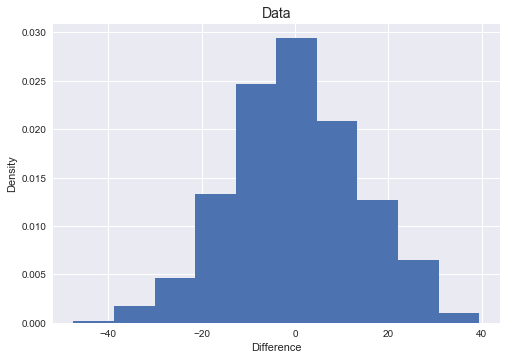

In [4]:
plt.title('Data', fontsize=14)
plt.hist(data['diff'], normed=True)
plt.xlabel('Difference')
plt.ylabel('Density');

### Conjugate prior for $\sigma^2$

According to [the internet](https://en.wikipedia.org/wiki/Conjugate_prior) I should use an inverse gamma conjugate prior for a normal likelihood with fixed $\mu$.

For our prior, I will try and create a distribution with an average around 169 and a fairly high variance. After playing around, I have settled on $\alpha = 10$ and $\beta = 1500$

In [10]:
n = len(data['diff'])
mu0 = 0
a_prior =  10
b_prior = 1500
a_post = a_prior + n / 2
b_post = b_prior + np.sum((data['diff'] - mu0)**2)/2

prior = invgamma(a=a_prior, scale=b_prior)
post = invgamma(a=a_post, scale=b_post)
t_prior = np.linspace(*prior.ppf([0.01, 0.99]))
t_post = np.linspace(*post.ppf([0.001, 0.999]))
prob = 1 - post.cdf(169)

print('Probability variance is > 169 = {:.3f}'.format(prob))
print('CI 95% = ({:.2f}, {:.2f})'.format(*post.interval(0.95)))

Probability variance is > 169 = 0.989
CI 95% = (172.02, 212.40)


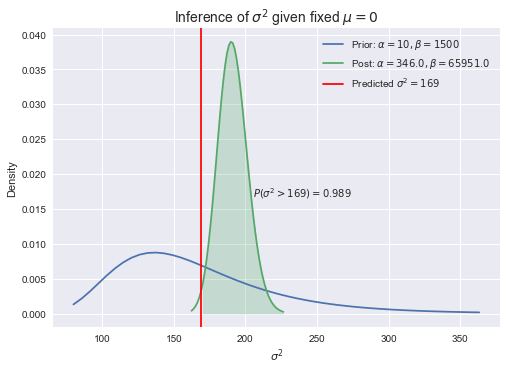

In [11]:
plt.title(r'Inference of $\sigma^2$ given fixed $\mu=0$', fontsize=14)
plt.plot(t_prior, prior.pdf(t_prior), label=rf'Prior: $\alpha={a_prior}, \beta={b_prior}$')
plt.plot(t_post, post.pdf(t_post), label=rf'Post: $\alpha={a_post}, \beta={b_post}$')
plt.fill_between(t_post[t_post>=169], 0, post.pdf(t_post[t_post>=169]), color='C1', alpha=.25)
plt.axvline(169, c='r', label=r'Predicted $\sigma^2=169$')
plt.xlabel(r'$\sigma^2$')
plt.ylabel('Density')
plt.text(205, post.pdf(204), rf'$P(\sigma^2>169)={prob:.3f}$')
plt.legend();

### Posterior Predictive Model
The posterior distrubtion based on a $\sigma^2\propto IG(\alpha, \beta)$ will have a smeared-guassian well-represented by the student's t distribution. We will model our posterior predictive using
$$
P(\tilde{Y} | Y) = t_{2\alpha} \left(\mu_0, \frac{\beta}{\alpha} \right)
$$

In [7]:
samples = post.rvs(10000)
postpred = norm(0, np.sqrt(samples))

postpred_t = t(2*a_post, 0, scale=np.sqrt(b_post/a_post))

x = np.linspace(-50, 50)
prob_diff = 1 - (postpred.cdf(30).mean() - postpred.cdf(-30).mean())
prob_diff_t = 1 - (postpred_t.cdf(30) - postpred_t.cdf(-30))

print(f'Probability that diff spread using simulation is > 30 = {prob_diff:.3f}')
print(f'Probability that diff spread using the t distribution is > 30 = {prob_diff_t:.3f}')

Probability that diff spread using simulation is > 30 = 0.030
Probability that diff spread using the t distribution is > 30 = 0.030


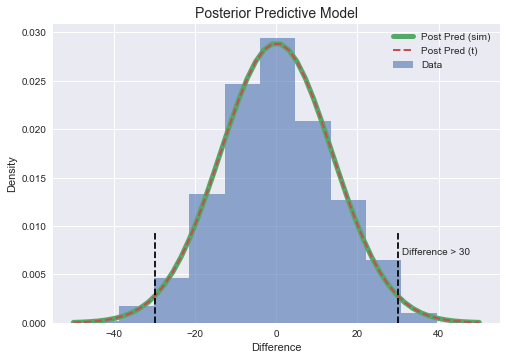

In [8]:
plt.title('Posterior Predictive Model', fontsize=14)
plt.hist(data['diff'], normed=True, alpha=0.6, label='Data')
pdf = [postpred.pdf(x_).mean() for x_ in x]
plt.plot(x, pdf, lw=5, label='Post Pred (sim)')
plt.plot(x, postpred_t.pdf(x), '--', lw=2, label='Post Pred (t)')
plt.axvline(-30, ymax=.3, c='k', ls='--')
plt.axvline(30, ymax=.3, c='k', ls='--')
plt.text(31, .007, 'Difference > 30')
plt.xlabel('Difference')
plt.ylabel('Density')
plt.legend();